### Imports

In [16]:
import os
import sys
import random

In [2]:
import numpy as np

In [3]:
import torch
from torch.utils.data import Dataset

In [4]:
import torchvision
import torchvision.transforms as transforms

In [38]:
from torchvision.transforms import InterpolationMode

In [70]:
# our library
from svetlanna import SimulationParameters
from svetlanna import elements
from svetlanna import beam_generator

In [5]:
import matplotlib.pyplot as plt

plt.style.use('dark_background')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 1. Raw [MNIST Dataset](https://www.kaggle.com/datasets/hojjatk/mnist-dataset)

Initialize a directory for a dataset:

In [6]:
data_filepath = './data'  # folder to store data

In [7]:
import ssl
# to solve the problem with cerificates while downloading a dataset using torchvision
# solution from: https://github.com/pytorch/pytorch/issues/33288#issuecomment-954160699
ssl._create_default_https_context = ssl._create_unverified_context

Load a dataset in the selected directory and create train and test datasets:

In [8]:
mnist_train_ds = torchvision.datasets.MNIST(
    root=data_filepath,
    train=True,  # for train dataset
    download=True,
    transform=transforms.ToTensor()  # transforms images to tensors
)

len(mnist_train_ds)

60000

torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])


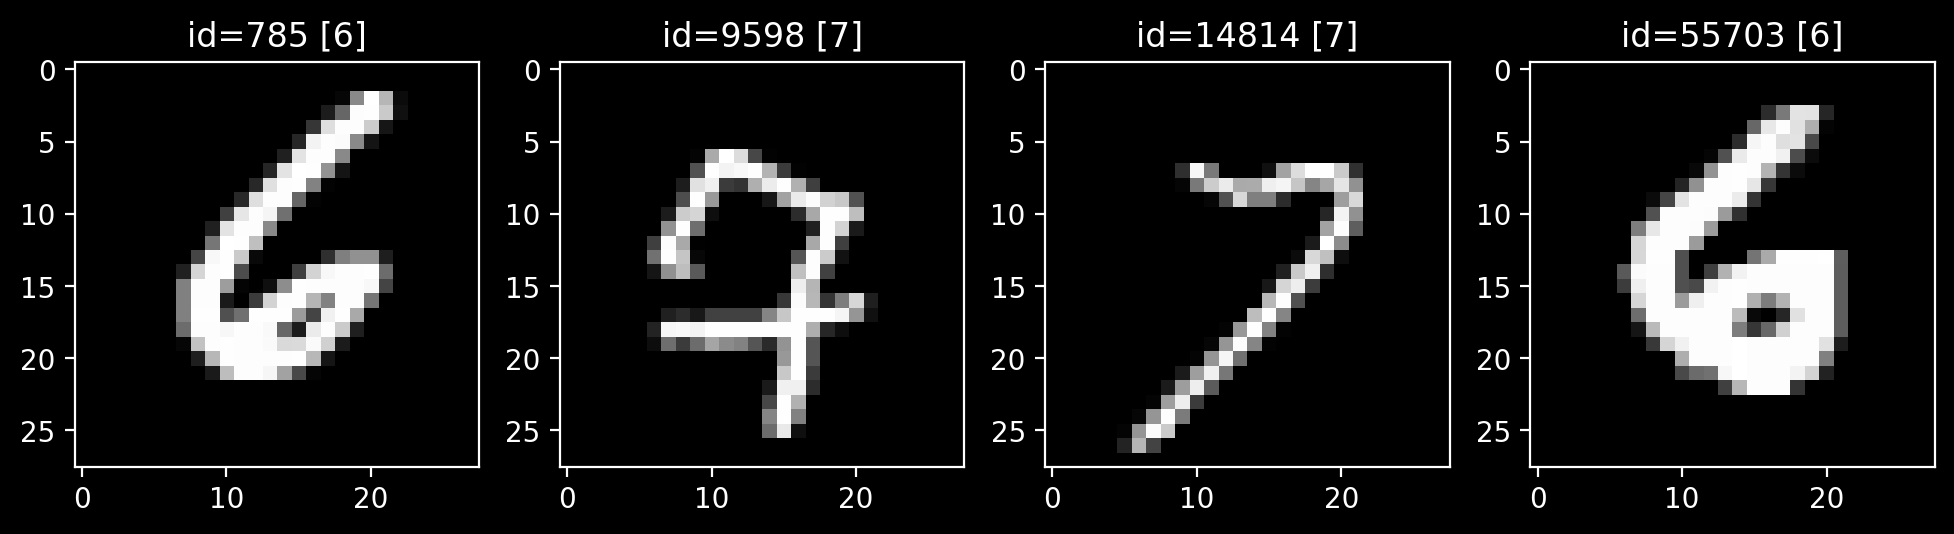

In [55]:
# plot several images
n_examples= 4  # number of examples to plot
# choosing indecies of images (from train) to plot
train_examples_ids = random.sample(range(len(mnist_train_ds)), n_examples)

fig, axs = plt.subplots(1, n_examples, figsize=(n_examples * 3, 3))
for ind_ex, ind_train in enumerate(train_examples_ids):
    image_tensor, target = mnist_train_ds[ind_train]
    axs[ind_ex].set_title(f'id={ind_train} [{target}]')

    resize = transforms.Resize(
        size=(28, 28),
        interpolation=InterpolationMode.NEAREST
    )
    # print(resize(image_tensor).shape)
    axs[ind_ex].imshow(resize(image_tensor)[0], cmap='gray')

plt.show()

Each image is of the size `torch.Size([1, 28, 28])`

In [9]:
mnist_test_ds = torchvision.datasets.MNIST(
    root=data_filepath,
    train=False,  # for test dataset
    download=True,
    transform=transforms.ToTensor()
)

len(mnist_test_ds)

10000

Check types for new objects:

In [10]:
# what is a type of the objects?
type(mnist_train_ds)

torchvision.datasets.mnist.MNIST

In [11]:
# check if created objects are instances of class Dataset
assert isinstance(mnist_train_ds, Dataset)

## 2. Dataset of wavefronts

### 2.1. Dataset class

In [77]:
class WavefrontsDatasetWithSLM(Dataset):
    """
    Dataset of wavefronts for a classification task for an optical network.
        Each raw image is used as a mask for SLM, that illuminated by a some beam field.
        A resulted wavefront will be an input tensor for an optical network.
    """
    def __init__(
        self, 
        images_ds: Dataset,
        sim_params: SimulationParameters,
        beam_field: torch.Tensor,
        system_before_slm: list,
        slm_levels: int = 256
    ):
        """
        Parameters
        ----------
        images_ds : torch.utils.data.Dataset
            Dataset of raw images and classes labels.
        sim_params : SimulationParameters
            Simulation parameters for a further opical network.
        beam_field : torch.Tensor
            A field of a beam (result of Beam.forward) that is used for an images wavefronts generation.
        system_before_slm : list(Element)
            A list of Elements between a beam and an SLM. The beam field is going through them before the SLM.
        slm_levels : int
            Number of phase quantization levels for the SLM, by default 256
        """
        self.images_ds = images_ds
        self.sim_params = sim_params

        self.beam_field = beam_field
        # QUESTION: then we can extract simulation parameters from every element? 
        self.system_before_slm = system_before_slm

        self.slm_levels = slm_levels

    def __getitem__(self, ind: int) -> tuple:
        """
        Parameters
        ----------
        ind : int
            Index of element to return.

        Returns
        -------
        tuple
            An element of dataset: tuple(wavefront tensor, class)
        """
        raw_image, label = self.images_ds[ind]
        # firstly, we need to resize an image to match simulation parameters (layers dimensions)
        # TODO: add a possibility to choose an interpolation function for images resizing
        resize = transforms.Resize(
            size=(self.sim_params.y_nodes, self.sim_params.x_nodes),
            interpolation=InterpolationMode.NEAREST,
        )
        resized_image = resize(raw_image)

        # secondly, we must somehow transform an image to a wavefront
        output_field = self.beam_field
        for element in system_before_slm:
            output_field = element.forward(input_field=output_field)

        # use an image as a mask for SLM
        mask = (resized_image * (self.slm_levels - 1)).to(torch.int32)  # maybe some function? what size?
        image_based_slm = elements.SpatialLightModulator(
            simulation_parameters=self.sim_params,
            mask=mask,
            number_of_levels=self.slm_levels
        )
        wavefront_image = image_based_slm.forward(output_field)
        
        return (wavefront_image, label)

### 2.2. Usage

#### 2.2.1. Input beam and system before SLM

In [100]:
# simulation parameters
x_nodes = 100
y_nodes = x_nodes

x_size = 20 * 1e-2  # [m]
y_size = x_size  # [m]

wavelength = 1000 * 1e-9  # [m]

sim_params = SimulationParameters(
    x_size=x_size,  # [m]
    y_size=y_size,  # [m]
    x_nodes=x_nodes,
    y_nodes=y_nodes,
    wavelength=wavelength  # [m]
)

In [121]:
# generate beam wavefront
# TODO: solve the problem with a zero distance (for obtaining a wavefront in plane)!
prop_distance = 1 * 1e-2  # [m]

beam_wavefront = beam_generator.GaussianBeam(
    simulation_parameters=sim_params
).forward(
    distance=prop_distance,  # [m]
    waist_radius=5 * 1e-2  # [m]
)

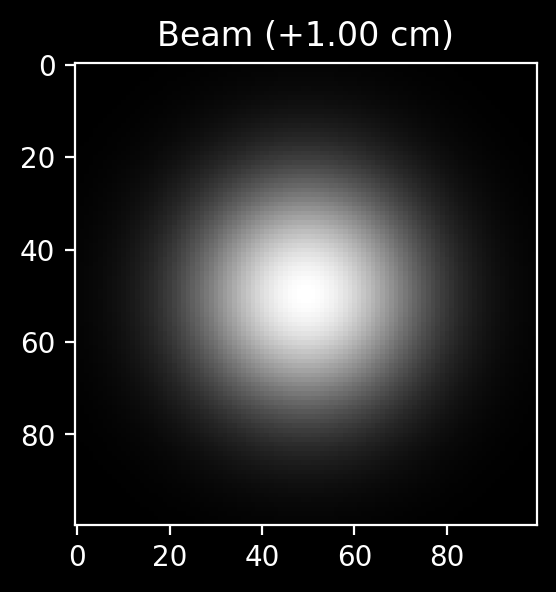

In [122]:
fig, ax0 = plt.subplots(1, 1, figsize=(3, 3))

ax0.set_title(f'Beam (+{prop_distance * 100:.2f} cm)')
ax0.imshow(beam_wavefront.abs(), cmap='gray')

plt.show()

In [123]:
# specify system before slm
free_space_1 = elements.FreeSpace(
    simulation_parameters=sim_params,
    distance=1 * 1e-2,  # [m]
    method='AS'
)

system_before_slm = [
    free_space_1
]

#### 2.2.2. Dataset of wavefronts

In [124]:
mnist_wf_train_ds = WavefrontsDatasetWithSLM(
    images_ds=mnist_train_ds,  # dataset of images
    sim_params=sim_params,  # simulation parameters
    beam_field=beam_wavefront,
    system_before_slm=system_before_slm,
    slm_levels=256
)

#### 2.2.3. Plot results

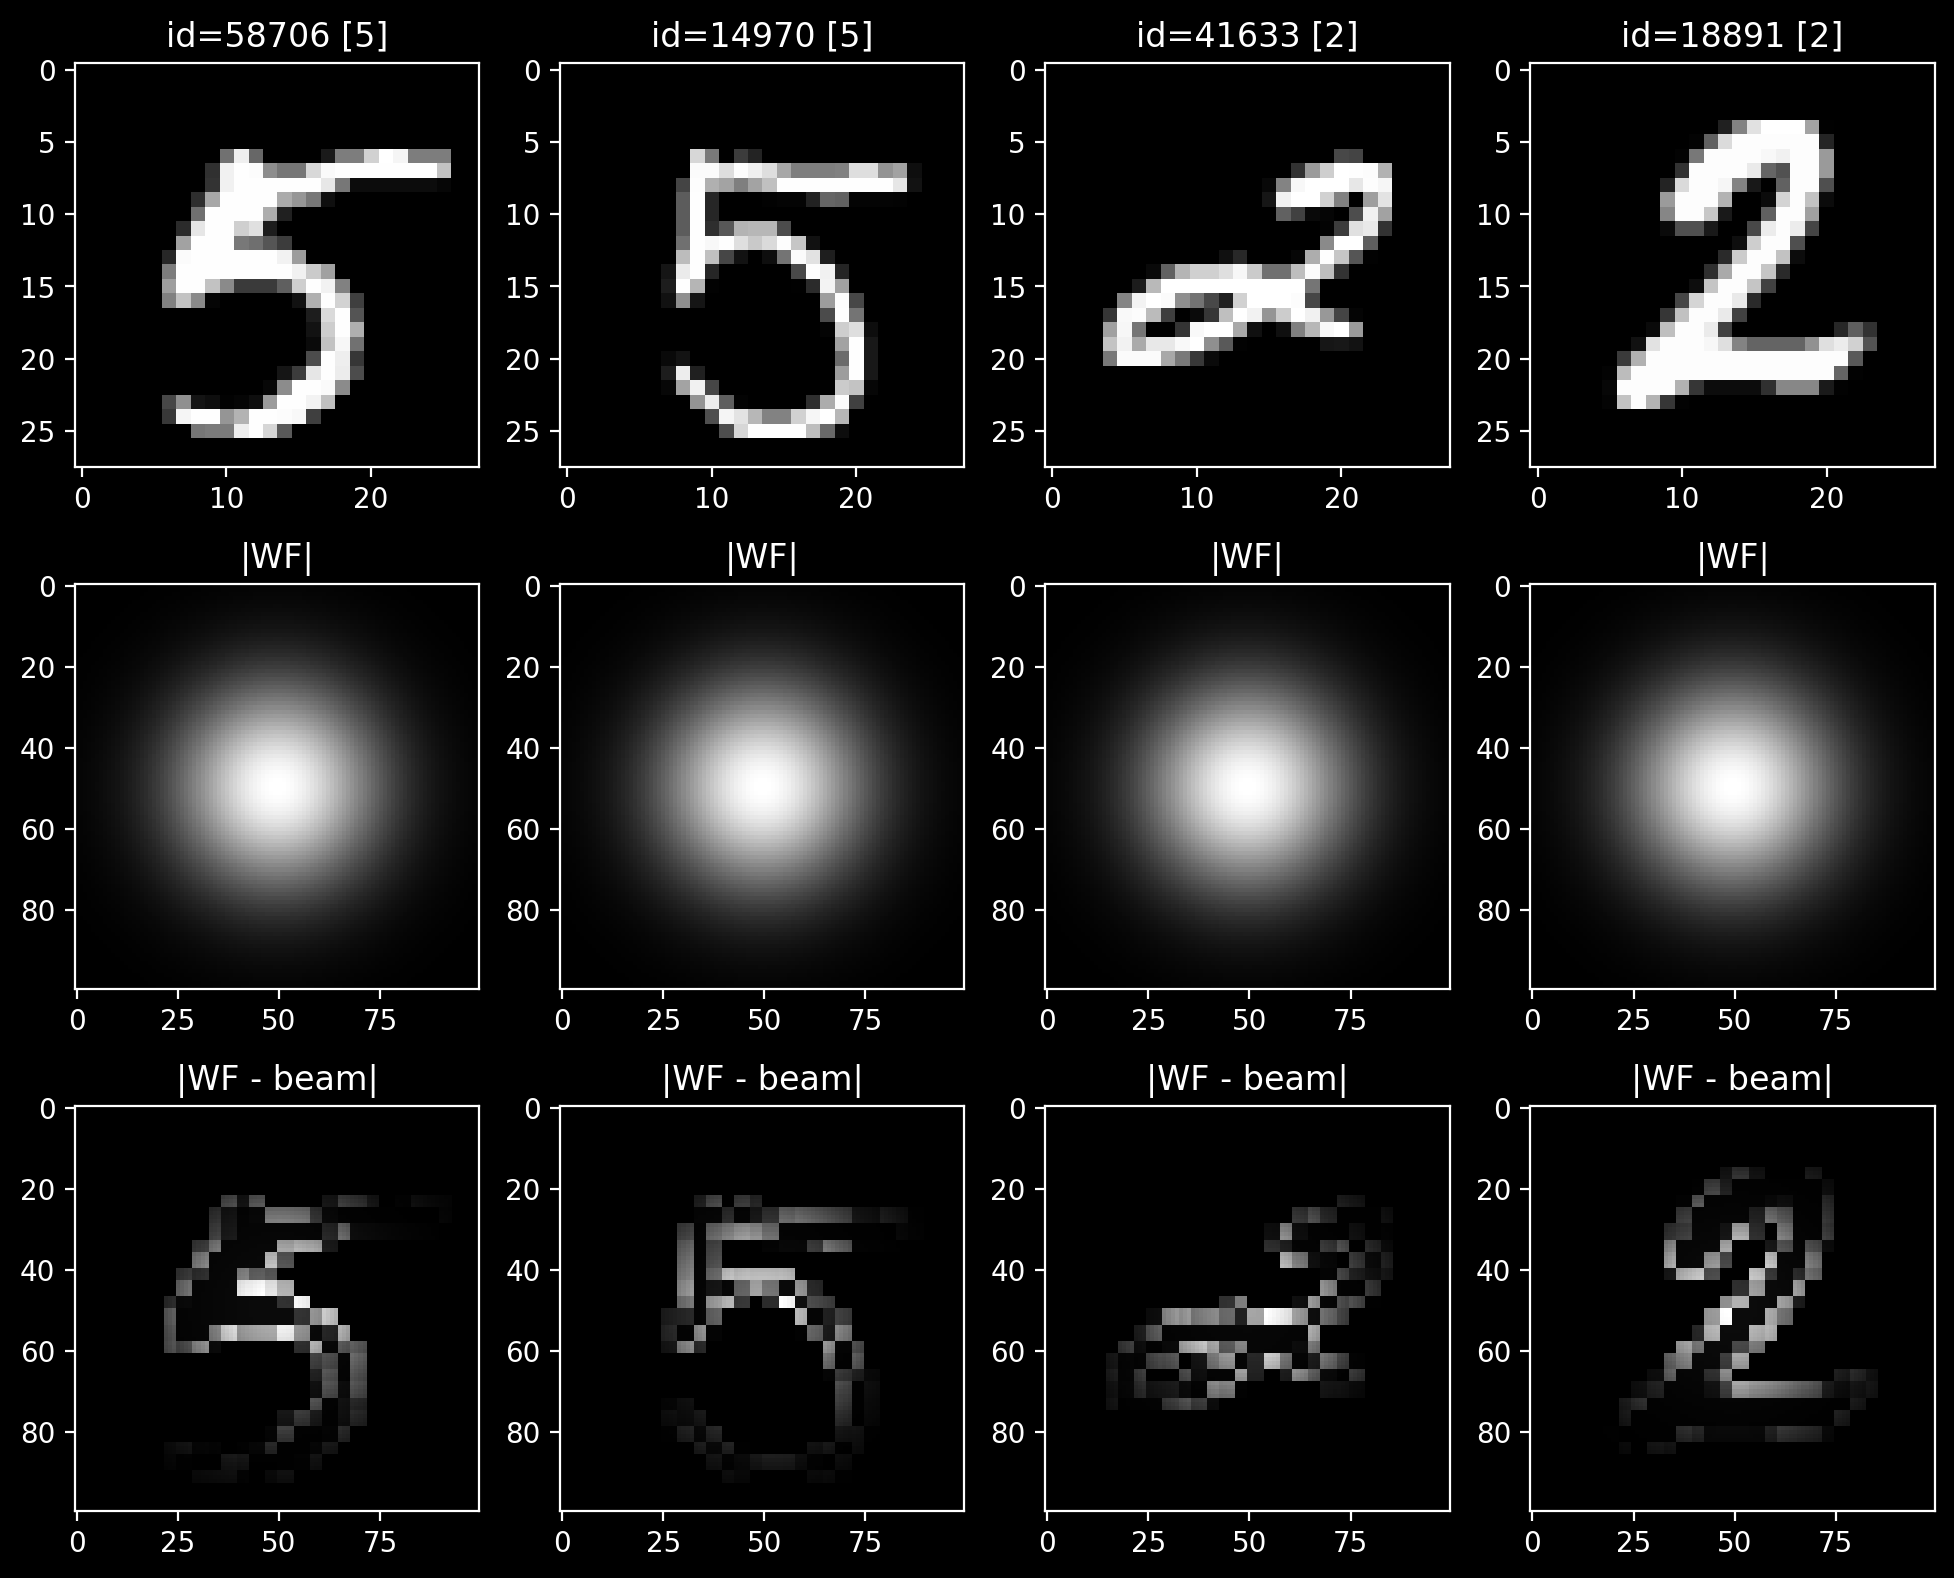

In [125]:
# plot several images
n_examples= 4  # number of examples to plot
# choosing indecies of images (from train) to plot
train_examples_ids = random.sample(range(len(mnist_train_ds)), n_examples)

all_examples_wavefronts = []

n_lines = 3
fig, axs = plt.subplots(n_lines, n_examples, figsize=(n_examples * 3, n_lines * 3.2))
for ind_ex, ind_train in enumerate(train_examples_ids):
    image_tensor, label = mnist_train_ds[ind_train]
    
    axs[0][ind_ex].set_title(f'id={ind_train} [{label}]')
    axs[0][ind_ex].imshow(image_tensor[0], cmap='gray')

    wavefront, wf_label = mnist_wf_train_ds[ind_train]
    assert wf_label == label
    all_examples_wavefronts.append(wavefront)

    axs[1][ind_ex].set_title(f'|WF|')
    axs[1][ind_ex].imshow(wavefront[0].abs(), cmap='gray')
    
    axs[2][ind_ex].set_title(f'|WF - beam|')
    axs[2][ind_ex].imshow((wavefront[0] - beam_wavefront).abs(), cmap='gray')

plt.show()

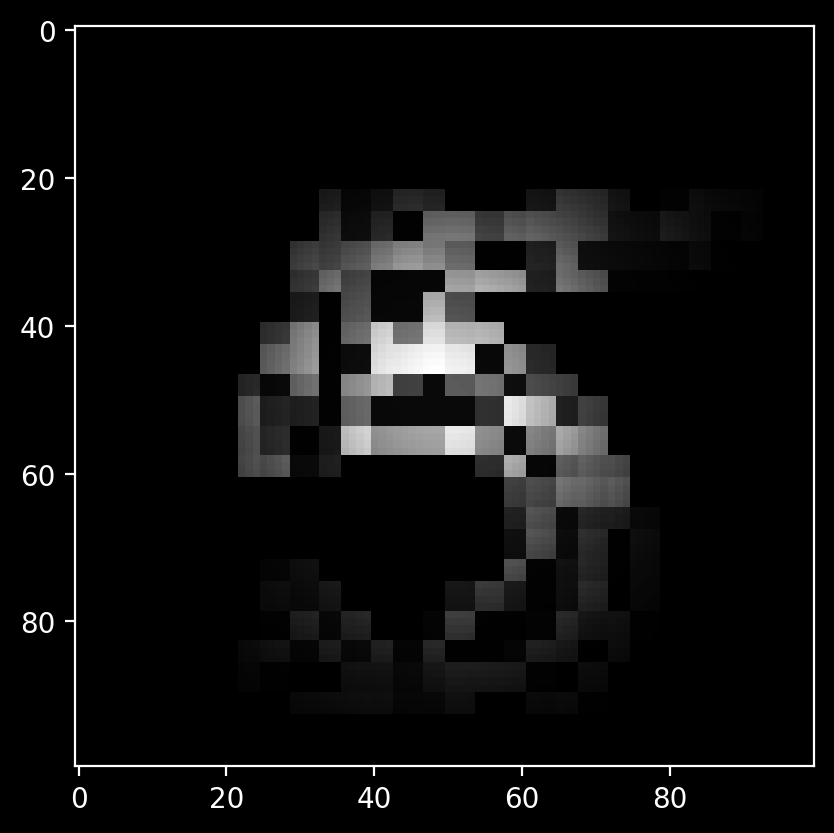

In [126]:
plt.imshow((all_examples_wavefronts[0] - all_examples_wavefronts[1]).abs()[0], cmap='gray')
plt.show()